## Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import os
from numpy.random import permutation
from sklearn import svm, datasets

from sacred import Experiment
from sacred.observers import FileStorageObserver

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='mobility-320516'

In [2]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

Downloading: 100%|██████████| 87020/87020 [00:06<00:00, 13163.39rows/s]

CPU times: user 2.25 s, sys: 178 ms, total: 2.43 s
Wall time: 15.4 s


In [3]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10153,2015-01-01,1,1,3,0,0,30
1,10165,2015-01-01,1,1,3,0,0,39
2,11372,2015-01-01,1,1,3,0,0,25
3,10036,2015-01-01,1,1,3,0,0,772
4,11514,2015-01-01,1,1,3,0,0,1


In [4]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### checking 'count' distribution

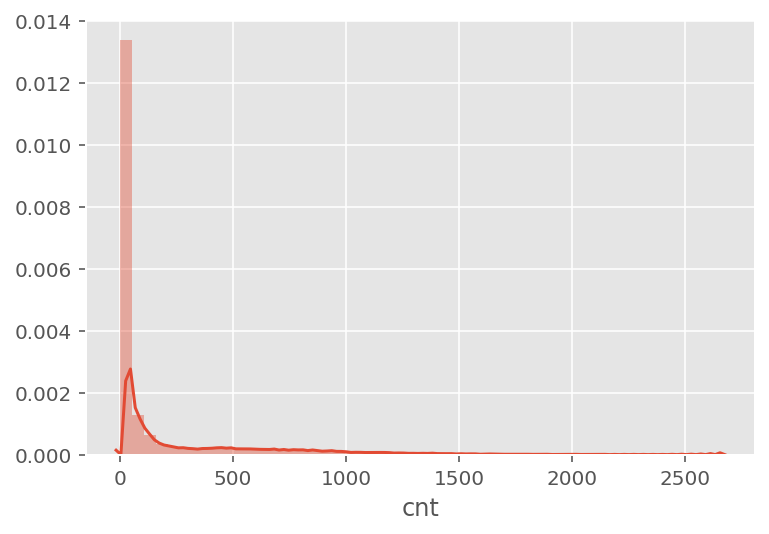

In [5]:
sns.distplot(base_df['cnt'])

- The distribution is skewed right

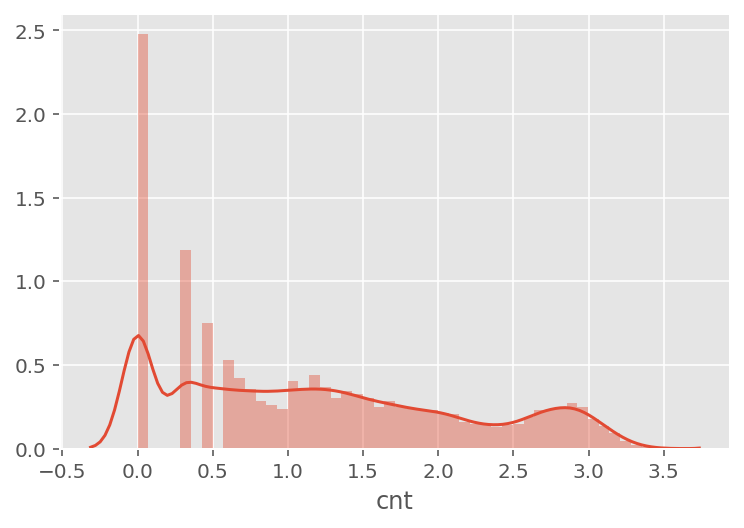

In [6]:
# perform log
sns.distplot(np.log10(base_df['cnt']))

In [7]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

In [8]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10153,2015-01-01,1,1,3,0,0,30,1.477121
1,10165,2015-01-01,1,1,3,0,0,39,1.591065
2,11372,2015-01-01,1,1,3,0,0,25,1.397940
3,10036,2015-01-01,1,1,3,0,0,772,2.887617
4,11514,2015-01-01,1,1,3,0,0,1,0.000000


### Train/Test set split

In [9]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [10]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10153,2015-01-01,1,1,3,0,0,30,1.477121
1,10165,2015-01-01,1,1,3,0,0,39,1.591065
2,11372,2015-01-01,1,1,3,0,0,25,1.397940
3,10036,2015-01-01,1,1,3,0,0,772,2.887617
4,11514,2015-01-01,1,1,3,0,0,1,0.000000


In [11]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65118,10153,2015-01-24,1,24,5,0,1,31,1.491362
65119,11415,2015-01-24,1,24,5,0,1,1,0.000000
65120,10279,2015-01-24,1,24,5,0,1,4,0.602060
65121,11372,2015-01-24,1,24,5,0,1,10,1.000000
65122,10110,2015-01-24,1,24,5,0,1,15,1.176091


In [12]:
# removing unnecessary columns
del train_df['pickup_hour']
del test_df['pickup_hour']

In [13]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [14]:
x_train = train_df.copy()
x_test = test_df.copy()

In [15]:
x_train.head()

,zip_code,month,day,weekday,hour,is_weekend
0,10153,1,1,3,0,0
1,10165,1,1,3,0,0
2,11372,1,1,3,0,0
3,10036,1,1,3,0,0
4,11514,1,1,3,0,0


## Simple regression

In [16]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.4313428 , 0.34248883, 1.32262996, ..., 1.87096929, 1.74068645,
       0.82611815])

In [17]:
# test_df['pred_log']= pred
# test_df['pred_reverse'] = 10**pred
# test_df['real_log'] = y_test_log
# test_df['real_raw'] = y_test_raw

In [18]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [19]:
evaluation(y_test_raw, 10**pred)

,mape,mae,mse
score,428.415375,126.535552,95916.687733


In [20]:
# evaluation(test_df['real_raw'], test_df['pred_reverse'])

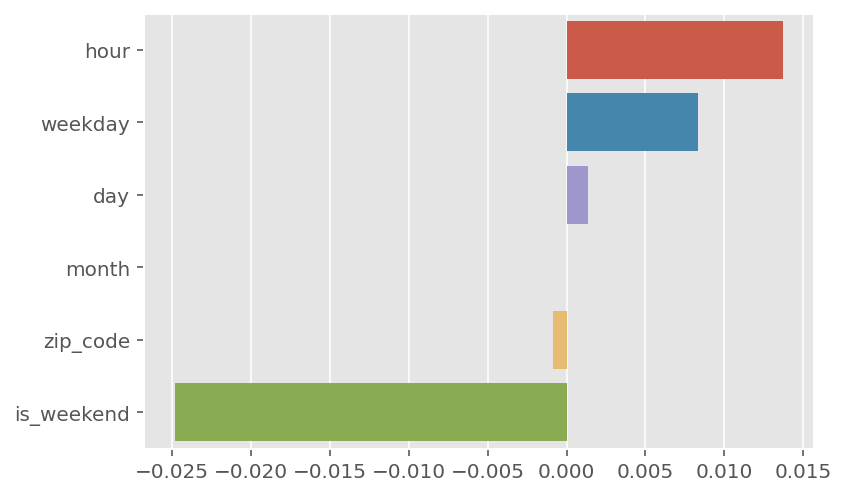

In [23]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

In [24]:
sl_ex = Experiment('nyc-demand-prediction_sl', interactive=True)

experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
sl_ex.observers.append(FileStorageObserver.create(experiment_dir))

In [25]:
@sl_ex.config
def config():
    fit_intercept=True
    normalize=False

In [26]:
@sl_ex.capture
def get_model(fit_intercept, normalize):
    return LinearRegression(fit_intercept, normalize)

In [27]:
# _log과 _run은 별도로 정의하지 않아도 함수의 인자로 사용 가능
@sl_ex.main
def run(_log, _run):
    lr_reg = get_model()
    lr_reg.fit(x_train, y_train_raw)
    pred = lr_reg.predict(x_test)
    # log File에 로그 저장
    _log.info("Predict End")
    score = evaluation(y_test_raw, pred)
    _run.log_scalar('model_name', lr_reg.__class__.__name__)
    
    # Metrics쪽에 저장하고 싶으면 아래처럼 사용
    _run.log_scalar('metrics', score.to_dict())
    
    # Result쪽에 저장하고 싶으면 아래처럼 사용
    return score.to_dict()


In [28]:
experiment_result = sl_ex.run()

INFO - nyc-demand-prediction_sl - Running command 'run'
INFO - nyc-demand-prediction_sl - Started run with ID "1"
INFO - run - Predict End
INFO - nyc-demand-prediction_sl - Result: {'mape': {'score': 3190.201327875615}, 'mae': {'score': 185.28793226544406}, 'mse': {'score': 78953.3426654162}}
INFO - nyc-demand-prediction_sl - Completed after 0:00:00


In [29]:
experiment_result.config

{'fit_intercept': True, 'normalize': False, 'seed': 985977149}

In [30]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    output_df = output_df.round(2)
    return output_df

In [31]:
parsing_output(1)

,model_name,experiment_num,config,mae,mape,mse
score,LinearRegression,1,"{'fit_intercept': True, 'normalize': False, 's...",185.29,3190.2,78953.34


## Label Encoding

In [32]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [33]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt,zip_code_le
0,10153,2015-01-01,1,1,3,0,0,30,1.477121,50
1,10165,2015-01-01,1,1,3,0,0,39,1.591065,53
2,11372,2015-01-01,1,1,3,0,0,25,1.397940,246
3,10036,2015-01-01,1,1,3,0,0,772,2.887617,33
4,11514,2015-01-01,1,1,3,0,0,1,0.000000,283


In [34]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [35]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt,zip_code_le
0,10153,2015-01-01,1,1,3,0,0,30,1.477121,50
1,10165,2015-01-01,1,1,3,0,0,39,1.591065,53
2,11372,2015-01-01,1,1,3,0,0,25,1.397940,246
3,10036,2015-01-01,1,1,3,0,0,772,2.887617,33
4,11514,2015-01-01,1,1,3,0,0,1,0.000000,283


In [36]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [37]:
del train_df['log_cnt']
del test_df['log_cnt']

In [38]:
train_df.head()

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,30,50
1,1,1,3,0,0,39,53
2,1,1,3,0,0,25,246
3,1,1,3,0,0,772,33
4,1,1,3,0,0,1,283


In [39]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [40]:
x_train = train_df.copy()
x_test = test_df.copy()

## XGBoost Regressor

In [41]:
xgb_ex = Experiment('nyc-demand-prediction_xgb', interactive=True)
xgb_ex.observers.append(FileStorageObserver.create(experiment_dir))

In [42]:
@xgb_ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [43]:
@xgb_ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [44]:
@xgb_ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    score = evaluation(y_test_raw, xgb_pred)
    
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)  
    _run.log_scalar('metrics', score.to_dict())

    return score.to_dict()


In [45]:
experiment_result = xgb_ex.run()

INFO - nyc-demand-prediction_xgb - Running command 'run'
INFO - nyc-demand-prediction_xgb - Started run with ID "2"
INFO - nyc-demand-prediction_xgb - Result: {'mape': {'score': 538.5201561766146}, 'mae': {'score': 57.67873599873819}, 'mse': {'score': 16512.3302373418}}
INFO - nyc-demand-prediction_xgb - Completed after 0:00:01


In [46]:
experiment_result.config

{'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 762312189}

In [47]:
parsing_output(2)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,2,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.68,538.52,16512.33


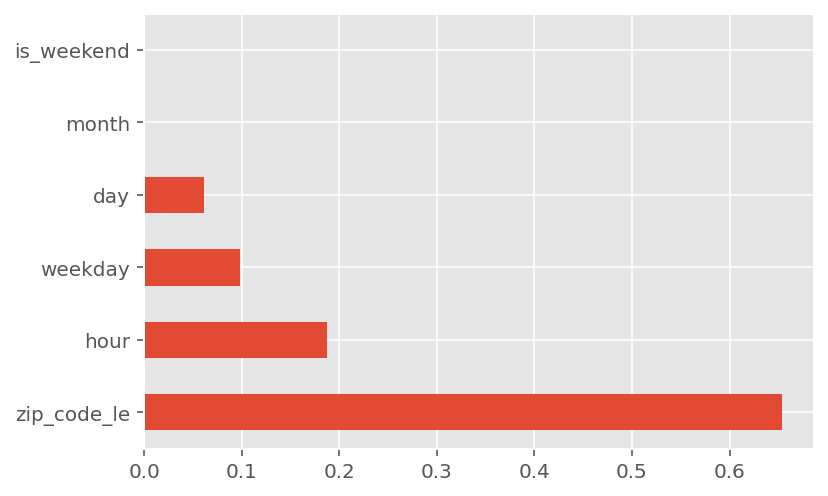

In [48]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Lightgbm Regressor

In [49]:
lgbm_ex = Experiment('nyc-demand-prediction_lgbm', interactive=True)
lgbm_ex.observers.append(FileStorageObserver.create(experiment_dir))

In [50]:
@lgbm_ex.config
def config():
    num_leaves=31
    max_depth=-1
    learning_rate=0.1
    n_estimators=100

In [51]:
@lgbm_ex.capture
def get_model(num_leaves, max_depth, learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

In [52]:
@lgbm_ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)
    lgbm_pred = lgbm_reg.predict(x_test)
    score = evaluation(y_test_raw, lgbm_pred)
    
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [53]:
experiment_result = lgbm_ex.run()

INFO - nyc-demand-prediction_lgbm - Running command 'run'
INFO - nyc-demand-prediction_lgbm - Started run with ID "3"
INFO - nyc-demand-prediction_lgbm - Result: {'mape': {'score': 421.6856972338653}, 'mae': {'score': 48.24149103960721}, 'mse': {'score': 13755.684889975497}}
INFO - nyc-demand-prediction_lgbm - Completed after 0:00:00


In [54]:
experiment_result.config

{'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'seed': 291597392}

In [55]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,3,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",48.24,421.69,13755.68


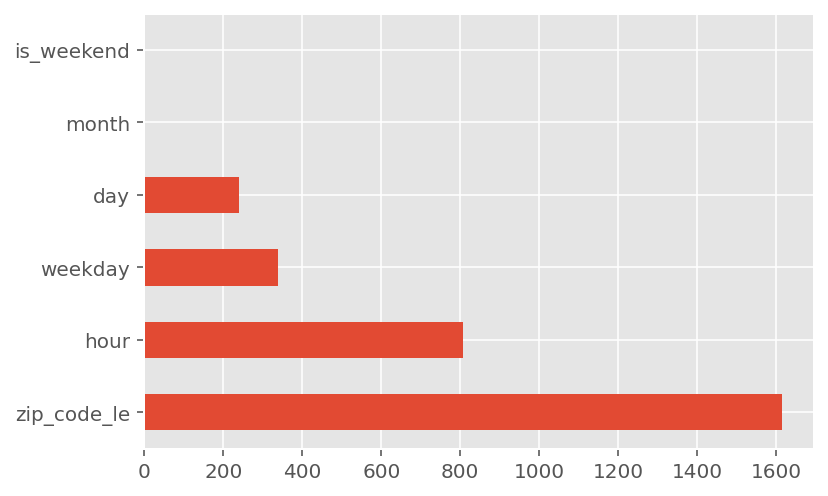

In [56]:
feat_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Random Forest Regressor

In [57]:
rf_ex = Experiment('nyc-demand-prediction_rf', interactive=True)
rf_ex.observers.append(FileStorageObserver.create(experiment_dir))

In [58]:
@rf_ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [59]:
@rf_ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [60]:
@rf_ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [61]:
experiment_result = rf_ex.run()

INFO - nyc-demand-prediction_rf - Running command 'run'
INFO - nyc-demand-prediction_rf - Started run with ID "4"
INFO - nyc-demand-prediction_rf - Result: {'mape': {'score': 184.4122462358499}, 'mae': {'score': 35.271637293397866}, 'mse': {'score': 12195.655162085655}}
INFO - nyc-demand-prediction_rf - Completed after 0:00:00


In [62]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 682873135}

In [63]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,4,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 682...",35.27,184.41,12195.66


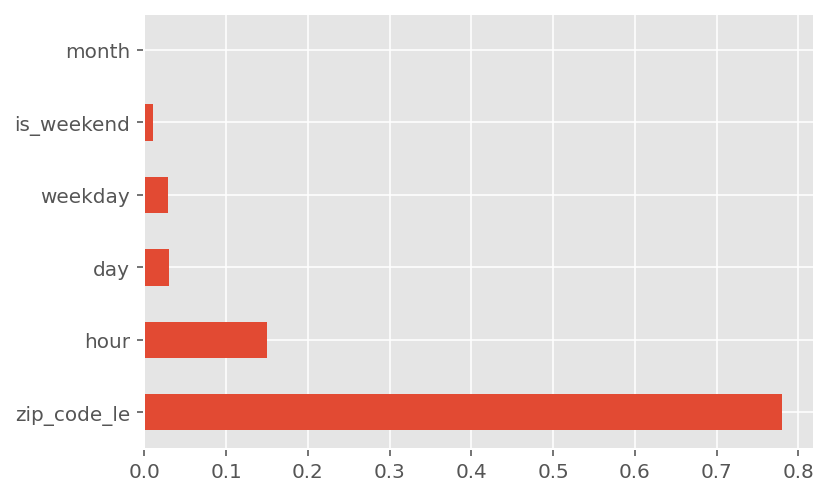

In [64]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [78]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le
65118,1,24,5,0,1,50
65119,1,24,5,0,1,258
65120,1,24,5,0,1,66
65121,1,24,5,0,1,246
65122,1,24,5,0,1,43


In [ ]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

### 합쳐서 뭐가 더 좋은지 알아보기

## Prediction vs Actual for Random Forest Regressor

In [82]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015

In [97]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])
del test_df['zip_code_le']

In [98]:
test_df.tail()

,month,day,weekday,hour,is_weekend,y_true,y_pred,year,zip_code,datetime
datetime,,,,,,,,,,
2015-01-31 23:00:00,1,31,5,23,1,16,14.6,2015,11377,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,9,6.9,2015,11372,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,580,546.5,2015,10021,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,11,12.4,2015,10172,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,2,3.5,2015,11232,2015-01-31 23:00:00


In [100]:
test_df = test_df.set_index('datetime')

In [101]:
test_df

,month,day,weekday,hour,is_weekend,y_true,y_pred,year,zip_code
datetime,,,,,,,,,
2015-01-24 00:00:00,1,24,5,0,1,31,16.6,2015,10153
2015-01-24 00:00:00,1,24,5,0,1,1,1.5,2015,11415
2015-01-24 00:00:00,1,24,5,0,1,4,7.8,2015,10279
2015-01-24 00:00:00,1,24,5,0,1,10,14.7,2015,11372
2015-01-24 00:00:00,1,24,5,0,1,15,23.1,2015,10110
...,...,...,...,...,...,...,...,...,...
2015-01-31 23:00:00,1,31,5,23,1,16,14.6,2015,11377
2015-01-31 23:00:00,1,31,5,23,1,9,6.9,2015,11372
2015-01-31 23:00:00,1,31,5,23,1,580,546.5,2015,10021


### By 'datetime'

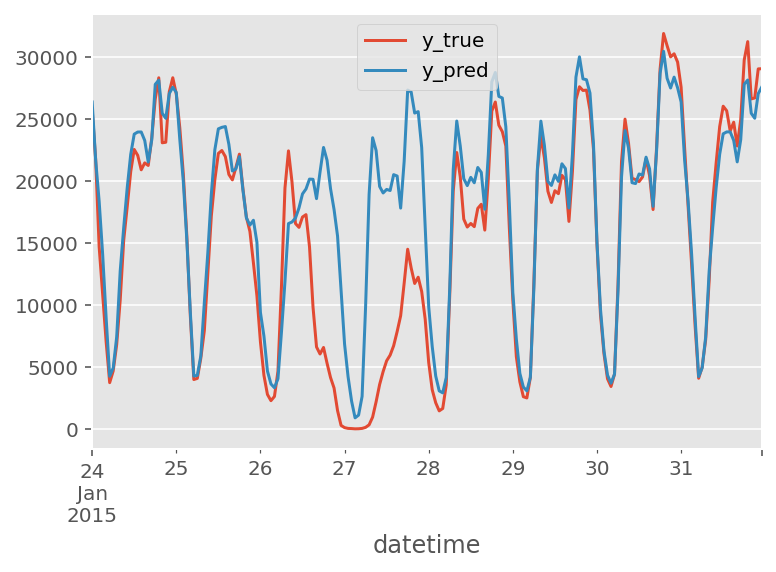

In [102]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot()

### By 'zip_code'

In [108]:
print(min(test_df['zip_code']))
print(max(test_df['zip_code']))

10001
14801


In [109]:
def visualize_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 14801))

In [110]:
visualize_by_zipcode(test_df)

interactive(children=(IntSlider(value=12401, description='zip_code', max=14801, min=10001), Output()), _dom_cl…

### By 'hour'

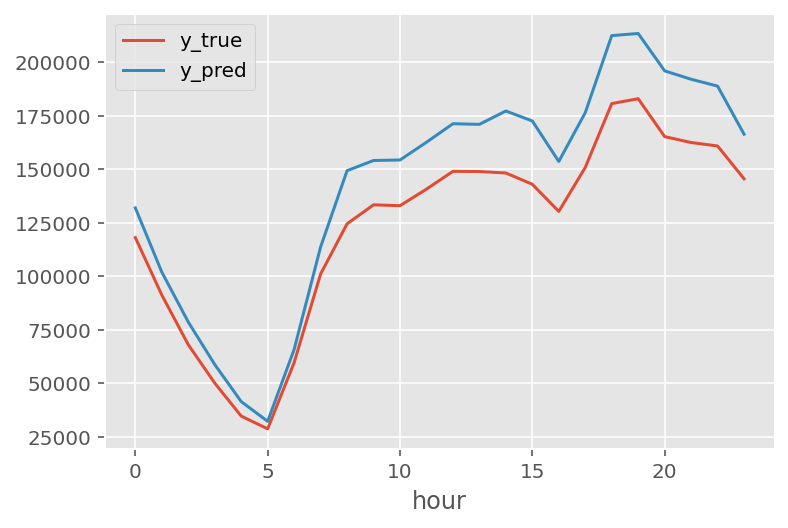

In [111]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot()

## Add 'time' for feature engineering

In [113]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (
  # Datetime만 distinct해서 가져옴(비어있지 않을것이라 가정)
  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (
  # zip_code만 distinct해서 가져옴(이외의 zip_code는 나오지 않을것이라 가정)
  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (
  # zip_code와 datetime을 join
  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (
  # zip_code, datetime별 수요 
  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (
  # zip_code, datetime 데이터에 수요값을 붙이고 없다면 0처리
  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
  LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq -   Elapsed 6.99 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 8.13 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 9.25 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 10.48 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 11.6 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 12.73 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 13.96 s. Waiting...
Downloading: 100%|██████████| 278256/278256 [00:35<00:00, 7766.80rows/s]
INFO - pandas_gbq.gbq - Total time taken 51.85 s.
Finished at 2021-07-24 22:53:32.


CPU times: user 10.9 s, sys: 659 ms, total: 11.6 s
Wall time: 51.9 s


In [114]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt
278251,14801,2015-01-31 19:00:00,1,31,5,19,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278252,14801,2015-01-31 20:00:00,1,31,5,20,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278253,14801,2015-01-31 21:00:00,1,31,5,21,1,0,0.0,1.0,0.0,0.0,0.01,0.0,0.0,0.0
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


In [115]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [116]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [117]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278059,14801,2015-01-23 19:00:00,1,23,4,19,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278060,14801,2015-01-23 20:00:00,1,23,4,20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278061,14801,2015-01-23 21:00:00,1,23,4,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278062,14801,2015-01-23 22:00:00,1,23,4,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278063,14801,2015-01-23 23:00:00,1,23,4,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373


In [118]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [119]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [120]:
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')
x_train = train_df.copy()
x_test = test_df.copy()

In [121]:
time_ex = Experiment('nyc-demand-prediction_time', interactive=True)
time_ex.observers.append(FileStorageObserver.create(experiment_dir))

In [122]:
@time_ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [123]:
@time_ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [124]:
@time_ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__ + str('_time'))    
    _run.log_scalar('metrics', score.to_dict())
    
    return score.to_dict()


In [126]:
experiment_result = time_ex.run()

INFO - nyc-demand-prediction_time - Running command 'run'
INFO - nyc-demand-prediction_time - Started run with ID "5"
INFO - nyc-demand-prediction_time - Result: {'mape': {'score': nan}, 'mae': {'score': 6.9374958221925125}, 'mse': {'score': 1022.1341445242869}}
INFO - nyc-demand-prediction_time - Completed after 0:00:01


In [127]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 374857509}

In [128]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor_time,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 374...",6.94,NaN,1022.13


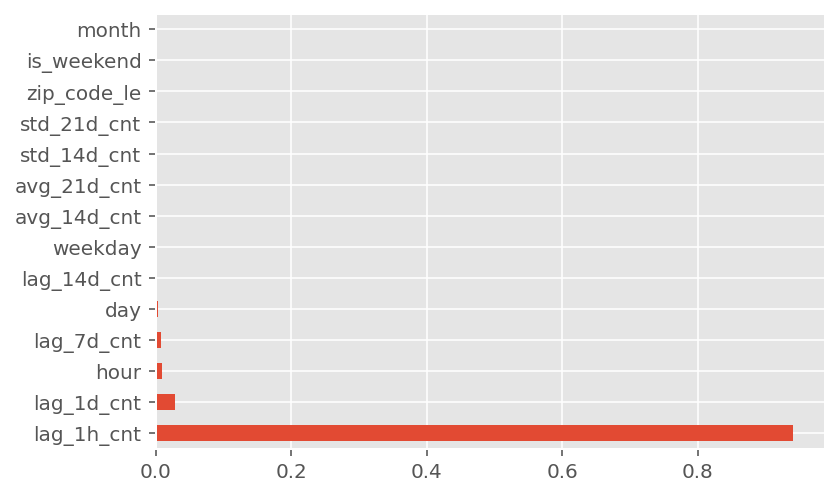

In [129]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

## Prediction vs Actual for RF with 'time' feature

In [130]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [131]:
test_df = test_df.set_index('datetime')

### By 'datetime'

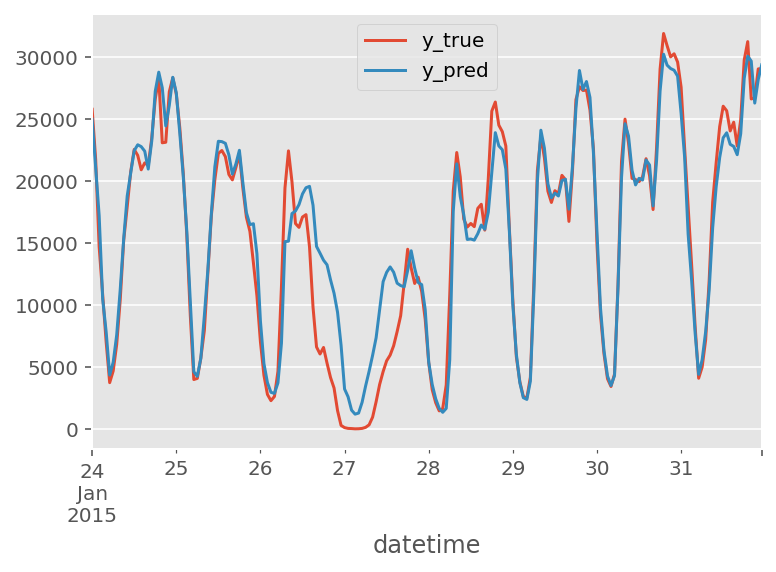

In [132]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot()

### By 'zip_code'

In [135]:
visualize_by_zipcode(test_df)

interactive(children=(IntSlider(value=12401, description='zip_code', max=14801, min=10001), Output()), _dom_cl…

### By 'hour'

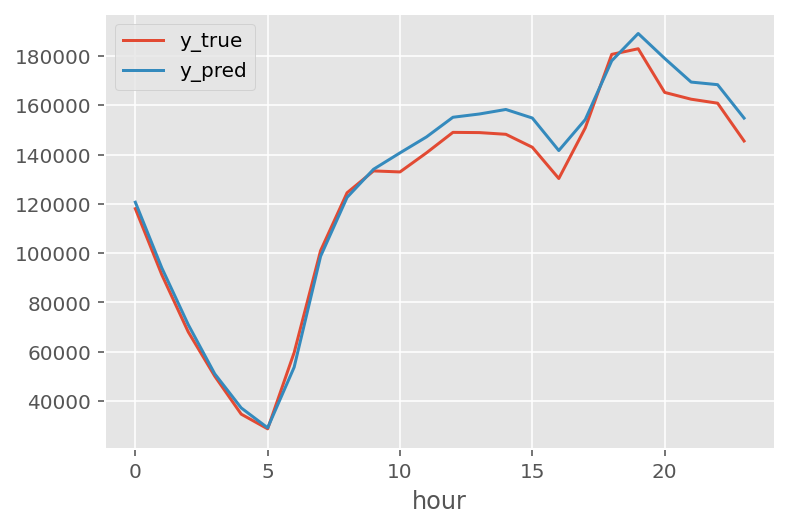

In [134]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot()